# LMNO

We use [Nishikwa](https://doi.org/10.1016/j.jelechem.2017.06.042) measurments data for LMNO

## Data visualization

We import the required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In this work we are given the currents at which each curve was measured and a relationship between these currents and the C rate.

In [2]:
currents = np.array([1, 2, 3, 5, 10])
crate = lambda i: 2.5 * i

the equilibrium potential is also given and we use the shear potential of the provided surface

In [3]:
eq_pot = 4.739
vcut = 0.15

we load the data of the curves

In [4]:
dfs = [pd.read_csv(f"data/nishikawa/{i}nA.csv", header=None) for i in currents]

and visualize the data before we work with it

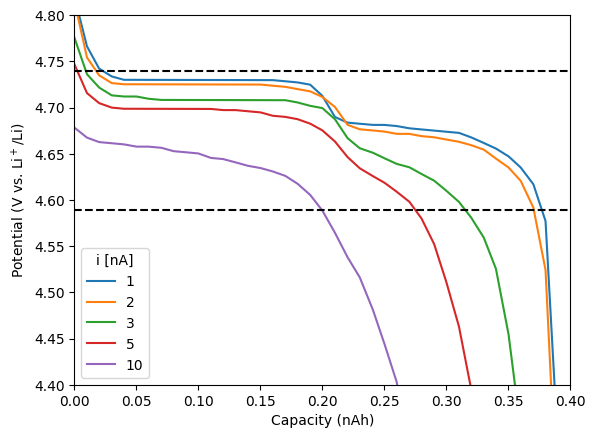

In [5]:
fig, ax = plt.subplots()

for i, df in zip(currents, dfs):
    ax.plot(df.iloc[:, 0], df.iloc[:, 1], label=f"{i}")

ax.axhline(y=eq_pot, color="k", linestyle="--")
ax.axhline(y=eq_pot - vcut, color="k", linestyle="--")

ax.set_xlim((0, 0.4))
ax.set_ylim((4.4, 4.8))
ax.set_xlabel("Capacity (nAh)")
ax.set_ylabel(r"Potential (V vs. Li$^+$/Li)")
ax.legend(title="i [nA]")
plt.show()

## Preprocessing

We can use the `preprocessing` module of `galpynostatic` to obtain the discharge capacities.

In [6]:
import galpynostatic
xmaxs = galpynostatic.preprocessing.GetDischargeCapacities(eq_pot).fit_transform(dfs)

We normalize this data between 0 and 1

In [7]:
soc = xmaxs / 0.38

And visualize this values versus the logarithmic value of the C-rate

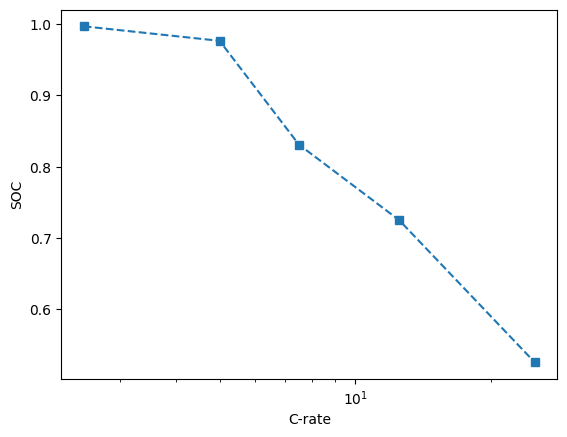

In [8]:
C_rates = np.asarray([crate(i) for i in currents]).reshape(-1, 1)

plt.plot(C_rates, soc, marker="s", linestyle="--")
plt.xlabel("C-rate")
plt.ylabel("SOC")
plt.xscale("log")
plt.show()

## Fitting

Using that the surface area is $8.04 \cdot 10^{-6} cm^2$ to obtain the diameter of the particle can be, assuming a simple spherical particle

In [9]:
d = np.sqrt(0.25 * 8.04e-6 / np.pi)
print(f"{d} cm")

0.0007998767850296815 cm


We load the spherical dataset

In [10]:
dataset = galpynostatic.datasets.load_spherical()

and fit on it

In [11]:
greg = galpynostatic.model.GalvanostaticRegressor(dataset, d, 3)

greg.fit(C_rates, soc)

## Results

The obtained diffusion coefficient and kinetic rate constant are

In [12]:
print(f"Diffusion coefficient: {greg.dcoeff_:.3e} cm^2/s")
print(f"Kinetic rate constant: {greg.k0_:.3e} cm/s")

Diffusion coefficient: 1.233e-09 cm^2/s
Kinetic rate constant: 1.233e-06 cm/s


with a mean squared error of

In [13]:
print(f"{greg.mse_:.6f}")

0.001885


We can estimate the optimal value for the characteristic length of the nanoparticle, i.e. the size to obtain 80% of the charge in 5 minutes.

In [14]:
new_d = galpynostatic.predict.t_minutes_length(greg)
print(f"{new_d:.6f} micrometers")

7.294963 micrometers


We plot data versus predictions

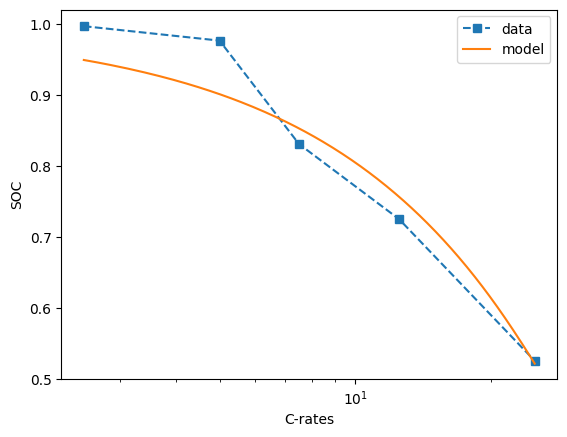

In [15]:
greg.plot.versus_data(C_rates, soc)

plt.ylim((0.5, 1.02))
plt.legend()
plt.show()

We can also plot the region of the map in which these points are located:

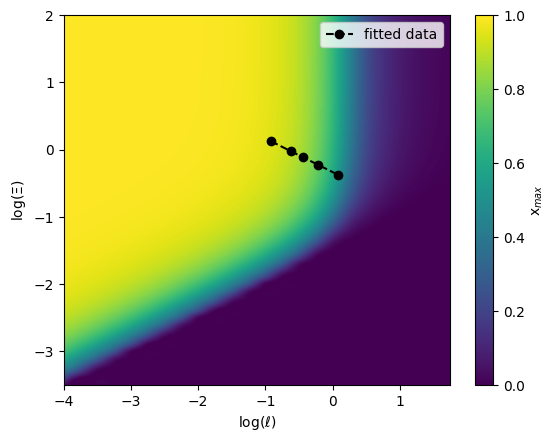

In [16]:
greg.plot.in_surface(C_rates)

plt.legend()
plt.show()